IOT Project - Sports Analytics (PlayArena)


*  Sohil Grandhi (ssg5428)
* Harshita Coneri (hpc5303)
* Thejasvi Velaga (tfv5097)
* Tanuj Namdeo (tpn5218)




**Problem Statement**  : Bat tracking (tennis, baseball, cricket) in 3D with embedded inertial sensors and/or ultrasound/RF sensors. Can you also detect the location on the bat where the ball hits?

Importing required packages

In [347]:
import csv
import pandas as pd
import os
import time
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
from datetime import datetime, timedelta,timezone
import matplotlib.dates as mdates
import sklearn.model_selection
import random as python_random
from PIL import Image
from sklearn.utils import resample
from numpy import mean,std
import itertools
from itertools import combinations
import pickle
# fix random seed for reproducibility
from numpy.random import seed
#metrics
from sklearn.metrics import r2_score,accuracy_score,f1_score,mean_squared_error,mean_absolute_error,classification_report, confusion_matrix, roc_auc_score
# preprocessing
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,MinMaxScaler,StandardScaler
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
# feature and model selection
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold,cross_val_score,GridSearchCV,train_test_split,cross_validate
# models
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVR,SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier,VotingClassifier

# tf and nn models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN,GRU,Dropout,Activation,Conv1D
from keras import regularizers

<Figure size 640x480 with 0 Axes>

In [348]:
# from google.colab import drive
# drive.mount('/content/drive')

Define constants

In [349]:
# file name
file_1='/content/drive/MyDrive/IOT_Project/Data/11 13/data_1.txt'
file_2='/content/drive/MyDrive/IOT_Project/Data/11 13/data_2.txt'

# final data that is already exixts in drive path 
final_data_file ="/content/drive/MyDrive/IOT_Project/code_base/Final_data/final_data.xlsx"
final_video_data_file ="/content/drive/MyDrive/IOT_Project/code_base/Final_data/final_video_data.xlsx"
final_sensor_gt_data_file ="/content/drive/MyDrive/IOT_Project/code_base/Final_data/final_sensor_gt_data.xlsx"
# shot images storage
drive_path="/content/"
main_folder="images"
saved_model_path = "drive/MyDrive/IOT_Project/code_base/Final_model/"

# model_names =["KNeighborsClassifier", "KNeighborsRegressor","SVR","SVC","KMeans","RFClassifier","RFRegressor","XGBoost","MLP","LSTM"]
# model_names =["KNeighborsClassifier", "KNeighborsRegressor","SVR","SVC","KMeans","RFClassifier","RFRegressor","XGBoost","ExtraTreesClassifier","MLPClassifier"]
model_names =["KNeighborsClassifier","SVC","KMeans","RFClassifier","XGBoost","ExtraTreesClassifier","MLPClassifier"] # removed regression models
saved_data_path = "drive/MyDrive/IOT_Project/code_base/Final_data/"
saved_main_file_name="final_data.xlsx"
saved_video_file_name = "final_video_data.xlsx"
saved_sensor_file_name = "final_sensor_gt_data.xlsx"

#column names 
cols=['Date','Time','Date_Time','Date_Time_ms','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez']
cols_main =['Time','Date_Time_ms','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez']
cols_main_1 =['Time','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez']
cols_main_2 =['shot_id','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez']
cols_main_norm =['ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez']

# ground truth
ground_truth_cols_main_1 =['shot_type']
ground_truth_cols_main_2 =['shot_kind']
ground_truth_cols =[ground_truth_cols_main_1,ground_truth_cols_main_2]
 # list for video related data

record_date="2022-11-13"
# used for croping the shot data and sensor data
video_granularity=16.683334
sensor_granularity=97

video_datapoints=60
sensor_datapoints=11

# shot timings on differtent vidoes
video1_st = ['0.02','0.11','0.18','0.24','0.30','0.37','0.44','1.01','1.09','1.16','1.26']
video1_et = ['0.03','0.12','0.19','0.25','0.31','0.38','0.45','1.02','1.10','1.17','1.27']
video2_st = ['0.09','0.17','0.25','0.33','0.41','0.52','0.59','1.19','1.33','1.54','2.19','2.28','2.37']
video2_et = ['0.10','0.18','0.26','0.34','0.42','0.53','1.01','1.20','1.34','1.55','2.20','2.29','2.38']
video3_st = ['0.18','0.24','0.52','1.07','1.23','2.00','2.07','2.18','2.27','2.34','2.41','2.58','3.04','3.13','3.21','3.26','3.49','3.58','4.28','4.34','4.42','4.58','5.05','5.12','5.18','5.33','5.43','6.00','6.17','6.28','6.36','6.55','7.07','7.15','7.26']
video3_et = ['0.19','0.25','0.53','1.08','1.24','2.01','2.08','2.19','2.28','2.35','2.42','2.59','3.05','3.14','3.22','3.27','3.50','3.59','4.29','4.35','4.44','4.59','5.06','5.13','5.19','5.34','5.44','6.01','6.18','6.29','6.37','6.56','7.08','7.16','7.27']
video4_st = ['0.03','0.09']
video4_et = ['0.04','0.10']
video5_st = ['0.04','0.11','0.22','0.29','0.37','0.44','0.53','1.08','1.16','1.38','1.47','1.56','2.03','2.10','2.18','2.31','2.42','2.49','2.57','3.06','3.18','3.31','3.41','3.47','3.55','4.07','4.19']
video5_et = ['0.05','0.12','0.23','0.30','0.38','0.45','0.54','1.09','1.17','1.39','1.48','1.57','2.04','2.11','2.19','2.32','2.43','2.50','2.58','3.07','3.19','3.32','3.42','3.48','3.56','4.08','4.20']


video1_save_time =datetime.strptime("2022-11-13 14:18:22", "%Y-%m-%d %H:%M:%S")
video2_save_time =datetime.strptime("2022-11-13 14:21:45", "%Y-%m-%d %H:%M:%S")
video3_save_time =datetime.strptime("2022-11-13 14:26:34", "%Y-%m-%d %H:%M:%S")
video4_save_time =datetime.strptime("2022-11-13 14:34:45", "%Y-%m-%d %H:%M:%S")
video5_save_time =datetime.strptime("2022-11-13 14:35:15", "%Y-%m-%d %H:%M:%S")

video1_end_time =datetime.strptime("2022-11-13 14:20:35", "%Y-%m-%d %H:%M:%S")
video2_end_time =datetime.strptime("2022-11-13 14:24:52", "%Y-%m-%d %H:%M:%S")
video3_end_time =datetime.strptime("2022-11-13 14:34:31", "%Y-%m-%d %H:%M:%S")
video4_end_time =datetime.strptime("2022-11-13 14:35:10", "%Y-%m-%d %H:%M:%S")
video5_end_time =datetime.strptime("2022-11-13 14:39:52", "%Y-%m-%d %H:%M:%S")

sensor1_start_time=datetime.strptime("2022-11-13 14:18:24.396", "%Y-%m-%d %H:%M:%S.%f")
sensor2_start_time=datetime.strptime("2022-11-13 14:35:16.085", "%Y-%m-%d %H:%M:%S.%f")

videoFile_1 = '/content/drive/MyDrive/IOT_Project/video_recording/11 13/IMG_1138.MOV'
videoFile_2 = '/content/drive/MyDrive/IOT_Project/video_recording/11 13/IMG_1139.MOV'
videoFile_3 = '/content/drive/MyDrive/IOT_Project/video_recording/11 13/IMG_1140.MOV'
videoFile_4 = '/content/drive/MyDrive/IOT_Project/video_recording/11 13/IMG_1141.MOV'
videoFile_5 = '/content/drive/MyDrive/IOT_Project/video_recording/11 13/IMG_1142.MOV'


Supporting functions

In [350]:
def get_seconds(time_str):
    # print('Time in hh:mm:ss:', time_str)
    # split in hh, mm, ss
    hh=0
    mm, ss = time_str.split('.')
    return int(hh) * 3600 + int(mm) * 60 + int(ss)

print('Time in Seconds:', get_seconds('40.10'))
print('Time in Seconds:', get_seconds('05.15'))
print('Time in Seconds:', get_seconds('00.32'))

Time in Seconds: 2410
Time in Seconds: 315
Time in Seconds: 32


In [351]:
def shot_images():

  #create a folder images for storing results,figures and model in drive
  list_folders=["shot_1"]

  if os.path.isdir(drive_path):
    if not os.path.exists(drive_path+main_folder):
      os.makedirs(os.path.join(drive_path,main_folder))

  if os.path.exists(drive_path+main_folder):
    for folder in list_folders:
      if not os.path.exists(drive_path+main_folder+"/"+folder):
        os.mkdir(os.path.join(drive_path+main_folder+"/", folder))

Checking final sensor,video,ground data is in drive or not

In [352]:
def data_drive_check(drive_path,saved_data_path,saved_main_file_name=None,saved_video_file_name=None,saved_sensor_file_name=None):
    hasData_seperate_file,hasData_final_file,isFinalData,isSensor,isVideo=False,False,False,False,False
    if os.path.isdir(drive_path):
      if os.path.exists(drive_path+saved_data_path+saved_main_file_name):
        #os.makedirs(os.path.join(drive_path,main_folder))
        isFinalData=True
      if os.path.exists(drive_path+saved_data_path+saved_video_file_name):
        isVideo=True
      if os.path.exists(drive_path+saved_data_path+saved_sensor_file_name):
        isSensor=True
      
      if (isFinalData== True):
        hasData_final_file =True
      if (isVideo == True and isSensor== True):
        hasData_seperate_file = True
      return hasData_final_file,hasData_seperate_file


# down sampling in order to add the video samples to train

In [353]:
def downsampling(final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data):
  #video 1
  final_video1_data_downsample = resample(final_video1_data_df,
             replace=True,
             n_samples=len(final_sensor1_data),
             random_state=42)

  #video 2
  final_video2_data_downsample = resample(final_video2_data_df,
             replace=True,
             n_samples=len(final_sensor2_data),
             random_state=42)
  #video 3
  final_video3_data_downsample = resample(final_video3_data_df,
             replace=True,
             n_samples=len(final_sensor3_data),
             random_state=42)
  #video 5
  final_video5_data_downsample = resample(final_video5_data_df,
             replace=True,
             n_samples=len(final_sensor5_data),
             random_state=42)
  return final_video1_data_downsample,final_video2_data_downsample,final_video3_data_downsample,final_video5_data_downsample

In [354]:
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

We Used 9-axis IMU sensor that records gyroscope(),Accelerometer() and magnetometer().


1.   We recorded first 60 shots of 2 players where each player played 30 shots which further divided into 10 : defense, 10:atatck, 10:random as sensor_data_1
2.   We recorded 30 shots of player which further divided into 10 : defense, 10:atatck, 10:random



Sensor Data and video Reading

In [355]:
def data_reading():
 
 # import data
 Sensor_data_1_org = pd.read_csv (r'/content/drive/MyDrive/IOT_Project/Data/11 13/data_1.txt', skiprows=1,delim_whitespace=True,names=['Date','Time','chip','chip_time','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez'])
 Sensor_data_2_org = pd.read_csv (r'/content/drive/MyDrive/IOT_Project/Data/11 13/data_2.txt',skiprows=1, delim_whitespace=True,names=['Date','Time','chip','chip_time','ax','ay','az','wx','wy','wz','Anglex','Angley','Anglez'])

 ground_truth =pd.read_csv (r'/content/drive/MyDrive/IOT_Project/Data/Ground_Truth.csv', skiprows=1,names=['video','shot_no','shot_kind','shot_type'])
 ground_truth_enc =pd.read_csv (r'/content/drive/MyDrive/IOT_Project/Data/Ground_Truth_encoded.csv', skiprows=1,names=['video','shot_no','shot_kind_str','shot_type_str','shot_kind','shot_type'])

 ground_truth =ground_truth_enc.copy()
 ground_truth.drop(columns=["video"], axis=1, inplace=True)
 # remove video4 data
 ground_truth.drop([59,60],inplace=True)
 ground_truth.reset_index(inplace=True)
 ground_truth.drop(columns=["index"], axis=1, inplace=True)
 
 return ground_truth,Sensor_data_1_org,Sensor_data_2_org


In [356]:
def video_reading():
  # reading the video data for all files
  cap_1 = cv2.VideoCapture(videoFile_1)
  cap_2 = cv2.VideoCapture(videoFile_2)
  cap_3 = cv2.VideoCapture(videoFile_3)
  cap_5 = cv2.VideoCapture(videoFile_5)

  # getting fps since fps iis same for all videoas i am taking the same fps
  fps = cap_1.get(cv2.CAP_PROP_FPS)

  # creating relevant time stamp lists to store
  # timestamps_1 = [cap_1.get(cv2.CAP_PROP_POS_MSEC)]
  # timestamps_2 = [cap_2.get(cv2.CAP_PROP_POS_MSEC)]
  # timestamps_3 = [cap_3.get(cv2.CAP_PROP_POS_MSEC)]
  # timestamps_4 = [cap_4.get(cv2.CAP_PROP_POS_MSEC)]
  # timestamps_5 = [cap_5.get(cv2.CAP_PROP_POS_MSEC)]

  timestamps_1 = []
  timestamps_2 = []
  timestamps_3 = []
  timestamps_5 = []

  # for video 1
  i=0
  sec=0

  while(cap_1.isOpened()):
    frame_exists, curr_frame = cap_1.read()
    frameRate = cap_1.get(cv2.CAP_PROP_FPS)
    sec = sec + frameRate 
    if frame_exists:
        i=i+1
        video_ms =cap_1.get(cv2.CAP_PROP_POS_MSEC)
        # if i>530 and i <595:
        #   cv2.imwrite(drive_path+main_folder+"/"+"shot_1/frame "+str(i)+"-"+str(video_ms) +" frames.jpg", curr_frame)
        timestamps_1.append(video_ms)
    else:
        break

  cap_1.release()

  # for video 2
  i=0
  sec=0

  while(cap_2.isOpened()):
    frame_exists, curr_frame = cap_2.read()
    frameRate = cap_2.get(cv2.CAP_PROP_FPS)
    sec = sec + frameRate 
    if frame_exists:
        i=i+1
        video_ms =cap_2.get(cv2.CAP_PROP_POS_MSEC)
        # if i>530 and i <595:
        #   cv2.imwrite(drive_path+main_folder+"/"+"shot_1/frame "+str(i)+"-"+str(video_ms) +" frames.jpg", curr_frame)
        timestamps_2.append(video_ms)
    else:
        break

  cap_2.release()

  # for video 3
  i=0
  sec=0

  while(cap_3.isOpened()):
    frame_exists, curr_frame = cap_3.read()
    frameRate = cap_3.get(cv2.CAP_PROP_FPS)
    sec = sec + frameRate 
    if frame_exists:
        i=i+1
        video_ms =cap_3.get(cv2.CAP_PROP_POS_MSEC)
        # if i>530 and i <595:
        #   cv2.imwrite(drive_path+main_folder+"/"+"shot_1/frame "+str(i)+"-"+str(video_ms) +" frames.jpg", curr_frame)
        timestamps_3.append(video_ms)
    else:
        break

  cap_3.release()

  # for video 5
  i=0
  sec=0

  while(cap_5.isOpened()):
    frame_exists, curr_frame = cap_5.read()
    frameRate = cap_5.get(cv2.CAP_PROP_FPS)
    sec = sec + frameRate 
    if frame_exists:
        i=i+1
        video_ms =cap_5.get(cv2.CAP_PROP_POS_MSEC)
        # if i>530 and i <595:
        #   cv2.imwrite(drive_path+main_folder+"/"+"shot_1/frame "+str(i)+"-"+str(video_ms) +" frames.jpg", curr_frame)
        timestamps_5.append(video_ms)
    else:
        break

  cap_5.release()

  # converting timestamps to secs from ms
  timestamps_1_s=[]
  timestamps_2_s=[]
  timestamps_3_s=[]
  timestamps_5_s=[]

  for i,time_ms in enumerate(timestamps_1):
    timestamps_1_s.append(round(time_ms/1000, 3))


  for i,time_ms in enumerate(timestamps_2):
    
    timestamps_2_s.append(round(time_ms/1000, 3))


  for i,time_ms in enumerate(timestamps_3):
    timestamps_3_s.append(round(time_ms/1000, 3))


  for i,time_ms in enumerate(timestamps_5):
    timestamps_5_s.append(round(time_ms/1000, 3))

  return timestamps_1,timestamps_2,timestamps_3,timestamps_5,timestamps_1_s,timestamps_2_s,timestamps_3_s,timestamps_5_s

Preprocessing of video and sensor

In [357]:
def video_data_preprocessing():

  # storing start and end time of the shots
  video1_st_s =[]
  video1_et_s =[]

  video2_st_s =[]
  video2_et_s =[]

  video3_st_s =[]
  video3_et_s =[]

  video4_st_s =[]
  video4_et_s =[]

  video5_st_s =[]
  video5_et_s =[]

  #video 1
  for val in video1_st:
    video1_st_s.append(int(get_seconds(val)))

  for val in video1_et:
    video1_et_s.append(int(get_seconds(val)))

  #video 2
  for val in video2_st:
    video2_st_s.append(int(get_seconds(val)))

  for val in video2_et:
    video2_et_s.append(int(get_seconds(val)))
  #vidoe 3
  for val in video3_st:
    video3_st_s.append(int(get_seconds(val)))

  for val in video3_et:
    video3_et_s.append(int(get_seconds(val)))

  #video 4
  for val in video4_st:
    video4_st_s.append(int(get_seconds(val)))

  for val in video4_et:
    video4_et_s.append(int(get_seconds(val)))

  #video 5
  for val in video5_st:
    video5_st_s.append(int(get_seconds(val)))

  for val in video5_et:
    video5_et_s.append(int(get_seconds(val)))

  return video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s

In [358]:
def sensor_data_preprocessing(Sensor_data_1_org,Sensor_data_2_org):
  Sensor_data_1_org["Date"] = pd.to_datetime(Sensor_data_1_org["Date"]).dt.strftime('%Y-%m-%d')
  Sensor_data_1_org["Date_Time_ms"] =Sensor_data_1_org['Date'] +" "+Sensor_data_1_org['Time']

  Sensor_data_2_org["Date"] = pd.to_datetime(Sensor_data_2_org["Date"]).dt.strftime('%Y-%m-%d')
  Sensor_data_2_org["Date_Time_ms"] =Sensor_data_2_org['Date'] +" "+Sensor_data_2_org['Time']

  #Formatting the date time column from string to date time
  Sensor_data_1_org['Date_Time_ms'] =  pd.to_datetime(Sensor_data_1_org['Date_Time_ms'], format='%Y-%m-%d %H:%M:%S')
  Sensor_data_1_org['Date_Time_ms'] =  pd.to_datetime(Sensor_data_1_org['Date_Time_ms'], format='%Y-%m-%d %H:%M:%S')

  Sensor_data_2_org['Date_Time_ms'] =  pd.to_datetime(Sensor_data_2_org['Date_Time_ms'], format='%Y-%m-%d %H:%M:%S')
  Sensor_data_2_org['Date_Time_ms'] =  pd.to_datetime(Sensor_data_2_org['Date_Time_ms'], format='%Y-%m-%d %H:%M:%S')

  #Removing milli seconds and storing it into another column
  Sensor_data_1_org['Date_Time'] =Sensor_data_1_org['Date_Time_ms'].dt.floor('s')
  Sensor_data_2_org['Date_Time'] =Sensor_data_2_org['Date_Time_ms'].dt.floor('s')

  #Delete chip and chip time column which are not related
  Sensor_data_1_org.drop(columns=["chip"], axis=1, inplace=True)
  Sensor_data_2_org.drop(columns=["chip"], axis=1, inplace=True)
  Sensor_data_1_org.drop(columns=["chip_time"], axis=1, inplace=True)
  Sensor_data_2_org.drop(columns=["chip_time"], axis=1, inplace=True)

  #Rearrange the columns
  Sensor_data_1_org = Sensor_data_1_org.reindex(cols, axis=1) # currently  using
  Sensor_data_2_org = Sensor_data_2_org.reindex(cols, axis=1) # currently  using

  # Consider colums which are going to be needed
  # Sensor_data_new_1_org = Sensor_data_1_org.filter(cols_main, axis=1) # currently not using
  # Sensor_data_new_2_org = Sensor_data_2_org.filter(cols_main, axis=1) # currently not using
  # Sensor_data_new_1 = Sensor_data_1.filter(cols_main_1, axis=1)
  # Sensor_data_new_2 = Sensor_data_2.filter(cols_main_1, axis=1)

  # splitting the sensor data based on video recording

  Sensor_data_1 = Sensor_data_1_org[(Sensor_data_1_org['Date_Time'] >= video1_save_time)].copy()
  Sensor_data_1 = Sensor_data_1[(Sensor_data_1['Date_Time']  <=  video1_end_time)]
  Sensor_data_1.reset_index(inplace=True)

  Sensor_data_2 = Sensor_data_1_org[(Sensor_data_1_org['Date_Time'] >= video2_save_time)].copy()
  Sensor_data_2 = Sensor_data_2[(Sensor_data_2['Date_Time']  <=  video2_end_time)]
  Sensor_data_2.reset_index(inplace=True)

  Sensor_data_3 = Sensor_data_1_org[(Sensor_data_1_org['Date_Time'] >= video3_save_time)].copy()
  Sensor_data_3 = Sensor_data_3[(Sensor_data_3['Date_Time']  <=  video3_end_time)]
  Sensor_data_3.reset_index(inplace=True)

  Sensor_data_5 =Sensor_data_2_org.copy()
 
  Sensor_data_1.drop(columns=["index"], axis=1, inplace=True)
  Sensor_data_2.drop(columns=["index"], axis=1, inplace=True)
  Sensor_data_3.drop(columns=["index"], axis=1, inplace=True)

  # Sensor_data_3.iloc[:1]
  return Sensor_data_1,Sensor_data_2,Sensor_data_3,Sensor_data_5

In [359]:
def sensor_data_aligning(Sensor_data_1,Sensor_data_2,Sensor_data_3,Sensor_data_5):
  # after spliting sennsor data based on video
  Sensor_data_1_align=Sensor_data_1.copy()
  Sensor_data_2_align=Sensor_data_2.copy()
  Sensor_data_3_align=Sensor_data_3.copy()
  Sensor_data_5_align=Sensor_data_5.copy()

  # consider only  1 sec to sensor data 2 even though video 4 and sensor 2 has 31 sec because we are considering the video 5 and sesonsor 2 and negelecting the vidoe 4 as it has only 2 shots if we consider vidoe 4 then we shoud have 
  Sensor_data_1_align['Date_Time_ms'] = pd.to_datetime(Sensor_data_1_align['Date_Time_ms']) - pd.to_timedelta(2, unit='s')
  # Sensor_data_2_align['Date_Time_ms'] = pd.to_datetime(Sensor_data_2_align['Date_Time_ms']) - pd.to_timedelta(2, unit='s')
  # Sensor_data_3_align['Date_Time_ms'] = pd.to_datetime(Sensor_data_3_align['Date_Time_ms']) - pd.to_timedelta(2, unit='s')
  Sensor_data_5_align['Date_Time_ms'] = pd.to_datetime(Sensor_data_5_align['Date_Time_ms']) - pd.to_timedelta(1, unit='s')

  Sensor_data_1_align['Date_Time'] = pd.to_datetime(Sensor_data_1_align['Date_Time']) - pd.to_timedelta(2, unit='s')
  # Sensor_data_2_align['Date_Time'] = pd.to_datetime(Sensor_data_2_align['Date_Time']) - pd.to_timedelta(2, unit='s')
  # Sensor_data_3_align['Date_Time'] = pd.to_datetime(Sensor_data_3_align['Date_Time']) - pd.to_timedelta(2, unit='s')
  Sensor_data_5_align['Date_Time'] = pd.to_datetime(Sensor_data_5_align['Date_Time']) - pd.to_timedelta(1, unit='s')

  return Sensor_data_1_align,Sensor_data_2_align,Sensor_data_3_align,Sensor_data_5_align

Final video and sensor data that has shots

In [360]:
def final_video_data(video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s,timestamps_1_s,timestamps_2_s,timestamps_3_s,timestamps_5_s):
  #shots time stamp in video
  final_video1_data = []
  final_video2_data = []
  final_video3_data = []
  final_video5_data = []

  # video 1
  for i,(et,st) in enumerate(zip(video1_et_s,video1_st_s)):
    shot_time= et-st
    # result = video1_save_time + timedelta(seconds=st)
    for time_ms in timestamps_1_s:
      if int(time_ms) == st and  (int(time_ms)<=(st+shot_time))  :
        final_video1_data.append(time_ms)

  # video 2
  for i,(et,st) in enumerate(zip(video2_et_s,video2_st_s)):
    shot_time= et-st
    # result = video2_save_time + timedelta(seconds=st)
    for time_ms in timestamps_2_s:
      if int(time_ms) == st and  (int(time_ms)<=(st+shot_time))  :
        final_video2_data.append(time_ms)

  # video 3
  for i,(et,st) in enumerate(zip(video3_et_s,video3_st_s)):
    shot_time= et-st
    # result = video3_save_time + timedelta(seconds=st)
    for time_ms in timestamps_3_s:
      if int(time_ms) == st and  (int(time_ms)<=(st+shot_time))  :
        final_video3_data.append(time_ms)

  # video 5
  for i,(et,st) in enumerate(zip(video5_et_s,video5_st_s)):
    shot_time= et-st
    # result = video5_save_time + timedelta(seconds=st)
    for time_ms in timestamps_5_s:
      if int(time_ms) == st and  (int(time_ms)<=(st+shot_time))  :
        final_video5_data.append(time_ms)
  
  # conversion of lists to df
  final_video1_data_df = pd.DataFrame (final_video1_data, columns = ['time_sec'])
  final_video2_data_df = pd.DataFrame (final_video2_data, columns = ['time_sec'])
  final_video3_data_df = pd.DataFrame (final_video3_data, columns = ['time_sec'])
  final_video5_data_df = pd.DataFrame (final_video5_data, columns = ['time_sec'])

  # print(final_video3_data_df.shape)
  # print(final_video5_data_df.shape)
  return final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df

In [361]:
def final_gt_sensor_data(ground_truth,Sensor_data_1_align,Sensor_data_2_align,Sensor_data_3_align,Sensor_data_5_align,video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s):
  #shots time stamp in sensor

  temp_df_1 = Sensor_data_1_align.copy()
  temp_df_2 = Sensor_data_2_align.copy()
  temp_df_3 = Sensor_data_3_align.copy()
  temp_df_5 = Sensor_data_5_align.copy()

  final_sensor1_data = pd.DataFrame()
  final_sensor2_data = pd.DataFrame()
  final_sensor3_data = pd.DataFrame()
  final_sensor5_data = pd.DataFrame()

  ground_truth_final = pd.DataFrame()
  ground_truth["shot_id"]=0
  count =0

  # sensor 1
  for i,(et,st) in enumerate(zip(video1_et_s,video1_st_s)):
    # shot_time= et-st
    shot_start_time = video1_save_time + timedelta(seconds=st)
    shot_end_time = video1_save_time + timedelta(seconds=et)

    temp_df = temp_df_1[(temp_df_1['Date_Time'] >= shot_start_time)].copy()
    temp_df = temp_df[(temp_df['Date_Time']  <=  shot_end_time)]
    count =count+1
    temp_df["shot_id"]=count
    final_sensor1_data = final_sensor1_data.append(temp_df, ignore_index=True)

    for j,val in enumerate(temp_df.to_numpy()):
      ground_truth["shot_id"].iloc[i]=count 
      ground_truth_final=ground_truth_final.append(ground_truth.iloc[i])

  # sensor 2
  for i,(et,st) in enumerate(zip(video2_et_s,video2_st_s)):
    # shot_time= et-st
    shot_start_time = video2_save_time + timedelta(seconds=st)
    shot_end_time = video2_save_time + timedelta(seconds=et)

    temp_df = temp_df_2[(temp_df_2['Date_Time'] >= shot_start_time)].copy()
    temp_df = temp_df[(temp_df['Date_Time']  <=  shot_end_time)]
    count =count+1
    temp_df["shot_id"]=count
    final_sensor2_data = final_sensor2_data.append(temp_df, ignore_index=True)


    for j,val in enumerate(temp_df.to_numpy()):
      ground_truth["shot_id"].iloc[i]=count 
      ground_truth_final=ground_truth_final.append(ground_truth.iloc[i])

  # sensor 3
  for i,(et,st) in enumerate(zip(video3_et_s,video3_st_s)):
    # shot_time= et-st
    shot_start_time = video3_save_time + timedelta(seconds=st)
    shot_end_time = video3_save_time + timedelta(seconds=et)

    temp_df = temp_df_3[(temp_df_3['Date_Time'] >= shot_start_time)].copy()
    temp_df = temp_df[(temp_df['Date_Time']  <=  shot_end_time)]
    count =count+1
    temp_df["shot_id"]=count
    final_sensor3_data = final_sensor3_data.append(temp_df, ignore_index=True)


    for j,val in enumerate(temp_df.to_numpy()):
      ground_truth["shot_id"].iloc[i]=count 
      ground_truth_final=ground_truth_final.append(ground_truth.iloc[i])

  # sensor 5
  for i,(et,st) in enumerate(zip(video5_et_s,video5_st_s)):
    # shot_time= et-st
    shot_start_time = video5_save_time + timedelta(seconds=st)
    shot_end_time = video5_save_time + timedelta(seconds=et)

    temp_df = temp_df_5[(temp_df_5['Date_Time'] >= shot_start_time)].copy()
    temp_df = temp_df[(temp_df['Date_Time']  <=  shot_end_time)]
    count =count+1
    temp_df["shot_id"]=count
    final_sensor5_data = final_sensor5_data.append(temp_df, ignore_index=True)
    
    for j,val in enumerate(temp_df.to_numpy()):
      ground_truth["shot_id"].iloc[i]=count  
      ground_truth_final=ground_truth_final.append(ground_truth.iloc[i])
      

  return ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data


Saving the the final video,sesnor,ground truth in drive if it didnt exist

In [362]:
def final_data_save(ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data,final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df):

  # with pd.ExcelWriter(final_video_data_file) as writer:
  with pd.ExcelWriter(final_data_file) as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    final_video1_data_df.to_excel(writer, sheet_name="video1", index=False)
    final_video2_data_df.to_excel(writer, sheet_name="video2", index=False)
    final_video3_data_df.to_excel(writer, sheet_name="video3", index=False)
    final_video3_data_df.to_excel(writer, sheet_name="video5", index=False)
    # if you want to save ground truth and sensor in seperate file comment below code and un comment the entire below with block
    final_sensor1_data.to_excel(writer, sheet_name="sensor1", index=False)
    final_sensor2_data.to_excel(writer, sheet_name="sensor2", index=False)
    final_sensor3_data.to_excel(writer, sheet_name="sensor3", index=False)
    final_sensor5_data.to_excel(writer, sheet_name="sensor5", index=False)
    ground_truth_final.to_excel(writer, sheet_name="ground_truth", index=False)

  # with pd.ExcelWriter(final_sensor_gt_data_file) as writer:
   
  #   # use to_excel function and specify the sheet_name and index
  #   # to store the dataframe in specified sheet
  #   final_sensor1_data.to_excel(writer, sheet_name="sensor1", index=False)
  #   final_sensor2_data.to_excel(writer, sheet_name="sensor2", index=False)
  #   final_sensor3_data.to_excel(writer, sheet_name="sensor3", index=False)
  #   final_sensor5_data.to_excel(writer, sheet_name="sensor5", index=False)
  #   ground_truth_final.to_excel(writer, sheet_name="ground_truth", index=False)

In [363]:
# need to update 
def data_loading():
  # declare global data frames
  global ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data,final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df


  ground_truth_final = pd.DataFrame()
  final_sensor1_data = pd.DataFrame()
  final_sensor2_data = pd.DataFrame()
  final_sensor3_data = pd.DataFrame()
  final_sensor5_data = pd.DataFrame()

  final_video1_data_df = pd.DataFrame()
  final_video2_data_df = pd.DataFrame()
  final_video3_data_df = pd.DataFrame()
  final_video5_data_df = pd.DataFrame()



  hasData_final_file,hasData_seperate_file =data_drive_check(drive_path,saved_data_path,saved_main_file_name,saved_video_file_name,saved_sensor_file_name)
  if hasData_final_file or hasData_seperate_file:
    # Load Excel file using Pandas with `sheet_name=None`
    df_dict = pd.read_excel(drive_path+saved_data_path+saved_main_file_name, sheet_name=None)
    # Get data from `video1` worksheet
    ground_truth_final = df_dict.get('ground_truth')
    final_sensor1_data = df_dict.get('sensor1')
    final_sensor2_data = df_dict.get('sensor2')
    final_sensor3_data = df_dict.get('sensor3')
    final_sensor5_data = df_dict.get('sensor5')

    final_video1_data_df = df_dict.get('video1')
    final_video2_data_df = df_dict.get('video2')
    final_video3_data_df = df_dict.get('video3')
    final_video5_data_df = df_dict.get('video5')
  elif hasData_seperate_file:
    # Load Excel file using Pandas with `sheet_name=None`
    df_dict_video = pd.read_excel(drive_path+saved_data_path+saved_video_file_name, sheet_name=None)
    df_dict_sensor_gt = pd.read_excel(drive_path+saved_data_path+saved_sensor_file_name, sheet_name=None)
    # Get data from `video1` worksheet
    ground_truth_final = df_dict_sensor_gt.get('ground_truth')
    final_sensor1_data = df_dict_sensor_gt.get('sensor1')
    final_sensor2_data = df_dict_sensor_gt.get('sensor2')
    final_sensor3_data = df_dict_sensor_gt.get('sensor3')
    final_sensor5_data = df_dict_sensor_gt.get('sensor5')

    final_video1_data_df = df_dict_video.get('video1')
    final_video2_data_df = df_dict_video.get('video2')
    final_video3_data_df = df_dict_video.get('video3')
    final_video5_data_df = df_dict_video.get('video5')
  else:
    #getting ground truth and sensor final data
    ground_truth,Sensor_data_1_org,Sensor_data_2_org=data_reading()

    Sensor_data_1,Sensor_data_2,Sensor_data_3,Sensor_data_5 = sensor_data_preprocessing(Sensor_data_1_org,Sensor_data_2_org)

    
    #getting  video final data
    timestamps_1,timestamps_2,timestamps_3,timestamps_5,timestamps_1_s,timestamps_2_s,timestamps_3_s,timestamps_5_s=video_reading()
    video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s = video_data_preprocessing()

    #final video df
    final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df = final_video_data(video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s,timestamps_1_s,timestamps_2_s,timestamps_3_s,timestamps_5_s)
    # print(final_video3_data_df.shape)
    # print(final_video5_data_df.shape)
    # aligning the sensor data with video time stamp
    Sensor_data_1_align,Sensor_data_2_align,Sensor_data_3_align,Sensor_data_5_align = sensor_data_aligning(Sensor_data_1,Sensor_data_2,Sensor_data_3,Sensor_data_5)
    # final sensors and ground truth
    ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data = final_gt_sensor_data(ground_truth,Sensor_data_1_align,Sensor_data_2_align,Sensor_data_3_align,Sensor_data_5_align,video1_st_s,video1_et_s,video2_st_s,video2_et_s,video3_st_s,video3_et_s,video5_st_s,video5_et_s)
    # if we video data in model we need to down sample the video data by using below line
    #final_video1_data_downsample,final_video2_data_downsample,final_video3_data_downsample,final_video5_data_downsample = downsampling(final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data)
    final_data_save(ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data,final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df)

  return ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data,final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df 


Model related functions

Selecting features 

In [364]:
def feature_selections(num_features):
  # Used for reference for splitting the train,test,eval based on number of features

  if num_features==9:
    input = [1,2,3,4,5,6,7,8,9]
    col_features=['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8','feature9']
  elif num_features==3:
    input = [1,2,3]
    col_features=['feature1','feature2','feature3']
  elif num_features==6:
    input = [1,2,3,7,8,9]
    col_features=['feature1','feature2','feature3','feature4','feature5','feature6']

  Comb = sum([list(map(list, combinations(input, i))) for i in range(1,len(input) + 1,1)], [])
  Comb_index = pd.DataFrame(Comb,columns =col_features)

  return Comb,Comb_index

correlation between features

In [365]:
def correlation_covarience(X):
  cor=x.corr()
  data_covariance = X.cov()
  
  fig, ax =plt.subplots(1,2,figsize=(15, 6))
  sns.heatmap(cor,annot=True,ax=ax[0])
  ax[0].set_title('correlation')
  sns.heatmap(data_covariance, square=True,ax=ax[1])
  ax[1].set_title('covarience')
  fig.suptitle('feature vs feature')
  # fig.show()
  fig_correlation_covarience = fig
  return fig_correlation_covarience

  

In [366]:
def feature_importance(model):
  feature_imp = pd.Series(model.feature_importances_,index=cols_main_norm).sort_values(ascending=False)
  sns.barplot(x=feature_imp, y=feature_imp.index)
  # Add labels to your graph
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Features')
  plt.title("Visualizing Important Features")
  plt.legend()
  # plt.show()
  plt_feature_importance = plt
  return plt_feature_importance

Hyper tunning the KNN,Kmeans. I got the k values by running the commented code at the below which is under heading " Find best k for KNN classifier and regressor"

In [367]:
# for ground truth perfect or goog
# knn regressor k=15
# KNN classifer k=7
# kmean 2

# for ground truth attack defense
# knn regressor k=94
# KNN classifer k=290,292,303
# kmean 2
def find_best_k(gt,model_name):
  n=0

  if gt =="shot_type":
    if model_name == "KNeighborsClassifier":
      n=7
    elif model_name == "KNeighborsRegressor":
      n=15
    else:
      n=2
  else:
    if model_name == "KNeighborsClassifier":
      n=290
    elif model_name == "KNeighborsRegressor":
      n=94
    else:
      n=2
  return n

Normalization

In [368]:
def normalization(X_train, X_test,norm ):
  global X_train_norm,X_test_norm
  train_min = X_train.min(axis=0) 
  train_max = X_train.max(axis=0)
  if norm=="max":
    X_test_norm = X_test / np.abs(X_train).max(axis=0)
    X_train_norm = X_train / np.abs(X_train).max(axis=0)
    
    

  elif norm=="mean_std":
    train_mean = np.mean(X_train)
    train_std = np.std(X_train)
    X_test_norm = (X_test - train_mean)/train_std
    X_train_norm =  (X_train - train_mean)/train_std


    if norm=="min_max" :
      X_train_norm = (X_train - train_min)/(train_max - train_min)
      # X_val_norm = (X_val - train_min)/(train_max - train_min)
      X_test_norm = (X_test - train_min)/(train_max - train_min)

  return X_train_norm, X_test_norm

splitting the x,y based on first 20 shots as train and 10 shots as test for each player instead of train_test_split

In [369]:
def shot_split(x,y,player_count):
  gt_cols=["shot_kind","shot_type","shot_id"]
  X_train = pd.DataFrame()
  X_test = pd.DataFrame()
  y_train = pd.DataFrame()
  y_test = pd.DataFrame()

  # if player_count =2 we are not considering the player 2 shots

  #player 1 train and test splits
  temp_df = x[(x['shot_id'] >= 1)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  19)]
  X_train = X_train.append(temp_df, ignore_index=True)

  temp_df = y[(y['shot_id'] >= 1)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  19)]
  y_train = y_train.append(temp_df, ignore_index=True)

  temp_df = x[(x['shot_id'] >= 20)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  29)]
  X_test = X_test.append(temp_df, ignore_index=True)

  temp_df = y[(y['shot_id'] >= 20)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  29)]
  y_test = y_test.append(temp_df, ignore_index=True)

  
  #player 2 train and test splits
  if player_count==3:
    temp_df = x[(x['shot_id'] >= 30)].copy()
    temp_df = temp_df[(temp_df['shot_id']  <=  49)]
    X_train = X_train.append(temp_df, ignore_index=True)

    temp_df = y[(y['shot_id'] >= 30)].copy()
    temp_df = temp_df[(temp_df['shot_id']  <=  49)]
    y_train = y_train.append(temp_df, ignore_index=True)

    temp_df = x[(x['shot_id'] >= 49)].copy()
    temp_df = temp_df[(temp_df['shot_id']  <=  59)]
    X_test = X_test.append(temp_df, ignore_index=True)

    temp_df = y[(y['shot_id'] >= 49)].copy()
    temp_df = temp_df[(temp_df['shot_id']  <=  59)]
    y_test = y_test.append(temp_df, ignore_index=True)

  #player 3 train and test splits
  temp_df = x[(x['shot_id'] >= 60)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  75)]
  X_train = X_train.append(temp_df, ignore_index=True)

  temp_df = y[(y['shot_id'] >= 60)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  75)]
  y_train = y_train.append(temp_df, ignore_index=True)

  temp_df = x[(x['shot_id'] >= 75)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  86)]
  X_test = X_test.append(temp_df, ignore_index=True)

  temp_df = y[(y['shot_id'] >= 75)].copy()
  temp_df = temp_df[(temp_df['shot_id']  <=  86)]
  y_test = y_test.append(temp_df, ignore_index=True)

  return X_train, X_test,y_train, y_test

Splitting the data to train and test

In [370]:
def data_split(norm,split,player_count,num_features,Sensor_data_final_new,ground_truth_cols_main,test_size):
  # remove it after we go the data
  # x = Sensor_data_final_new.copy()
  X_train, X_test,y_train, y_test = None,None,None,None
  X_train_plot, X_test_plot,y_train_plot, y_test_plot = None,None,None,None
  x = Sensor_data_final_new.filter(cols_main_1, axis=1)
  x_shotid = Sensor_data_final_new.filter(cols_main_2, axis=1)

  y = ground_truth_final.filter(ground_truth_cols_main, axis=1)
  x_cv = Sensor_data_final_new.filter(cols_main_norm, axis=1)
  if split =="train_test":
    X_train, X_test,y_train, y_test = train_test_split(x,y,random_state=104, test_size=test_size,shuffle=True)

    # x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)
  else:
    X_train, X_test,y_train, y_test = shot_split(x_shotid,ground_truth_final,player_count)
    x=x_shotid.copy()

  X_train_plot, X_test_plot,y_train_plot, y_test_plot = X_train, X_test,y_train, y_test
  train = X_train.copy()
  test = X_test.copy()

  # y_train = to_categorical(y_train)
  # y_test = to_categorical(y_test) 
  y_train = y_train.filter(ground_truth_cols_main, axis=1)
  y_test = y_test.filter(ground_truth_cols_main, axis=1)

  ground_truth_category =y_train.shape[1]

  Comb,Comb_index = feature_selections(num_features)
  X_train= X_train.iloc[0:len(x)+1,Comb[-1]].copy()
  X_test= X_test.iloc[0:len(x)+1,Comb[-1]].copy()

  print(norm)
  # X_train_norm,X_test_norm= normalization(X_train,norm),normalization(X_test,norm)
  X_train_norm,X_test_norm= normalization(X_train,X_test,norm)

  # prepare output data if not enoded in csv we need to run the below line
  # y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
  #else we are using already encoded csv file
  y_train_enc, y_test_enc = y_train.copy(),y_test.copy()
  y_train_enc =tf.reshape(y_train_enc, [-1])
  y_test_enc =tf.reshape(y_test_enc, [-1])
  print(y_train_enc.shape)
  print(X_train_norm.shape)
  print("\n")
  # print(ground_truth_category)
  return x_cv,x_shotid,x,y,X_train,X_test,X_train_norm,X_test_norm,y_train,y_test,y_train_enc, y_test_enc,ground_truth_category,X_train_plot, X_test_plot,y_train_plot, y_test_plot

Model class

In [371]:
class PlayArena():
  def __init__(self, mod_name,n_estimators,random_state,num_features,model_type,epochs,batch_size,n):
    self.mod_name = mod_name
    self.n_estimators = n_estimators
    self.random_state = random_state
    self.num_features = num_features
    self.model_type = model_type
    self.epochs = epochs
    self.batch_size = batch_size
    self.n =n
    # self.X = X
    # self.Y = Y
    # self.model = model

  def Model(self):
    # print(self.mod_name)
    
    if self.mod_name == "KNeighborsClassifier":
      model = KNeighborsClassifier(n_neighbors=self.n)

    if self.mod_name == "KNeighborsRegressor":
      model = KNeighborsRegressor(n_neighbors=self.n)

    if self.mod_name == "KMeans":
        model = KMeans(n_clusters=self.n)

    if self.mod_name == "SVR":
        model = SVR(kernel='rbf')

    if self.mod_name == "SVC":
        model = SVC()
    if self.mod_name == "RFClassifier":
        model = RandomForestClassifier(n_estimators=self.n_estimators,random_state=self.random_state)

    if self.mod_name == "RFRegressor":
        model = RandomForestRegressor(random_state=self.random_state)

    if self.mod_name == "XGBoost":
      model = XGBClassifier(objective='binary:logistic',
                          booster='gbtree')
      
    if self.mod_name == "ExtraTreesClassifier":
      model = ExtraTreesClassifier(random_state=123)

    if self.mod_name=="linear":
      model = Sequential()
      model.add(Dense(1, input_dim=self.num_features)) 
      model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

    
    if self.mod_name == "MLPClassifier":
      model = MLPClassifier()
  
    if self.mod_name == "MLP":
      model = Sequential()
      inputs = tf.keras.Input(shape=(self.num_features,))
      layer_1 = Dense(20)(inputs)
      layer_2 = Dense(30, activation = "sigmoid")(layer_1)
      layer_3 = Dense(ground_truth_category, activation="sigmoid")(layer_2)
      model = tf.keras.Model(inputs=inputs, outputs=layer_3)
      # compile the keras model
      model.compile(loss='mse', optimizer='adam', metrics=["accuracy"]) # tf.keras.metrics.CategoricalAccuracy()

    if self.mod_name == "LSTM":
      model = Sequential()
      model.add(keras.layers.LSTM(units=64, input_shape=(self.num_features,1), return_sequences=False))
      # inputs = tf.keras.Input(shape=(num_features,))
      # layer_1 = LSTM(64, return_sequences=False,activation = None)(inputs)
      # dense_layer_1 = Dense(64, activation = None)(layer_1)
      # dropout_1 = Dropout(0.1)(dense_layer_1)
      # layer_2 = LSTM(64,return_sequences=False, activation = None)(dropout_1)
      # dense_layer_2 = Dense(64, activation = None)(layer_2)
      # dropout_2 = Dropout(0.1)(dense_layer_2)
      # layer_3 = LSTM(64,return_sequences=False, activation = None)(dropout_2)
      # dropout_3 = Dropout(0.1)(layer_3)
      # layer_4 = Dense(ground_truth_category, activation=None)(dropout_3)
      # dropout_5 = Dropout(0.1)(layer_4)
      # model = tf.keras.Model(inputs=inputs, outputs=layer_4)
      # compile the keras model
      model.compile(loss='mse', optimizer='adam', metrics=["accuracy"]) # tf.keras.metrics.CategoricalAccuracy()
    
    # print(model)
    return  model

  def Training(self,model):
      if self.model_type== "NN" and self.mod_name != "MLPClassifier":
        # fit the keras model on the dataset
        history = model.fit(X_train_norm, y_train_enc,validation_split=0.1, epochs=self.epochs, batch_size=self.batch_size,shuffle=True, verbose=0)
      else:
        history =model.fit(X_train_norm, y_train_enc)
      return history
    
  def Predict(self,model,X):
      preds = model.predict(X)
      if self.model_type =="NN" and self.mod_name != "MLPClassifier":
        preds = preds[:,0]
      return preds
    
  def Evaluate(self,model,X,Y):
      _, accuracy = model.evaluate(X, Y, verbose=0)
      return accuracy

  def MSE(self,model,X,Y):
      global R2,score
      score =0
      pred = self.Predict(model,X)
      # print(Y.shape)
      if self.mod_name == "RFClassifier" or self.mod_name == "KNeighborsClassifier" or self.mod_name == "SVC" or self.mod_name == "KMeans" or self.mod_name == "XGBoost" or self.mod_name == "MLPClassifier" or self.mod_name == "ExtraTreesClassifier":
        R2 =accuracy_score(Y, pred)
        score = model.score(X, Y)
      else:
        R2 = r2_score(Y,pred)
      MSE = mean_squared_error(Y,pred)
      RMSE = math.sqrt(MSE)

      return R2,MSE,RMSE,score

In [372]:
def output(n_estimators,random_state,num_features,model_type,epochs,batch_size,gt):
  accuracy_train,accuracy_test=None,None
  # list for storing for all models
  accuracy_train_model,accuracy_test_model=[],[]
  R2_train_model,MSE_train_model,RMSE_train_model,score_train_model =[],[],[],[]
  R2_test_model,MSE_test_model,RMSE_test_model,score_test_model=[],[],[],[]
  n=1
  pred_train_model,pred_test_model=[],[]
  
  best_model,best_model_name,best_R2_test=None,[],0
  for i in range(0,len(model_names)):
    print(model_names[i])
    #seeting seed
    # np.random.seed(seed)
    # python_random.seed(seed)
    tf.random.set_seed(seed)

    if model_names[i] == "MLP" or model_names[i] == "LSTM" or model_names[i]  == "MLPClassifier":
      model_type ="NN"
    # calling model
    if model_type =="N":
      n=find_best_k(gt,model_names[i])
    playArena =PlayArena(model_names[i],n_estimators,random_state,num_features,model_type,epochs,batch_size,n)
    model=playArena.Model()
    history = playArena.Training(model)

    # save model
    pickle.dump(model, open(saved_model_path+model_names[i]+"_"+y.columns[0]+".pkl", 'wb'))

    # training prediction and score calculation
    pred_train = playArena.Predict(model,X_train_norm)
    R2_train,MSE_train,RMSE_train,score_train = playArena.MSE(model,X_train_norm,y_train_enc)

    R2_train_model.append(R2_train)
    MSE_train_model.append(MSE_train)
    RMSE_train_model.append(RMSE_train)
    score_train_model.append(score_train*100)

    pred_train_model.append(pred_train)

    # testing prediction and score calculation
    pred_test = playArena.Predict(model,X_test_norm)
    R2_test,MSE_test,RMSE_test,score_test = playArena.MSE(model,X_test_norm,y_test_enc)

    R2_test_model.append(R2_test)
    MSE_test_model.append(MSE_test)
    RMSE_test_model.append(RMSE_test)
    score_test_model.append(score_test*100)
    
    pred_test_model.append(pred_test)
    # # for best model based on ground truth 
    # if best_R2_test < R2_test:
    #   best_R2_test = R2_test
    #   best_model = model
    #   best_model_name.append(model_names[i])

    if model_type =="NN" and model_names[i] != "MLPClassifier":
      accuracy_train =playArena.Evaluate(model,X_train_norm,y_train_enc)
      accuracy_test =playArena.Evaluate(model,X_test_norm,y_test_enc)

      accuracy_train_model.append(accuracy_train*100)
      accuracy_test_model.append(accuracy_test*100)
    print("\n")  
    print('R2 test = '+ str(R2_test))
    # print('MSE test = '+ str(MSE_test))
    # print('RMSE test = '+ str(RMSE_test))
    if model_type =="NN" and model_names[i] !="MLPClassifier":
      print('accracy test = '+ str(accuracy_test*100))
    else:
      print('score test = '+ str(score_test*100))
    print("\n")

    print('R2 train = '+ str(R2_train))
    # print('MSE train = '+ str(MSE_train))
    # print('RMSE train = '+ str(RMSE_train))
    if model_type =="NN" and model_names[i] !="MLPClassifier":
      print('accracy train = '+ str(accuracy_train*100))
    else:
      print('score train = '+ str(score_train*100))
    print("\n")
  # for best model based on ground truth 
  best_R2_test = np.max(R2_test_model)
  index = R2_test_model.index(best_R2_test)
  best_model_name.append(model_names[index])
  # print("Best Model "+ model_names[index])
  return model,best_R2_test,best_model,best_model_name,R2_train_model,score_train_model,R2_test_model,score_test_model,accuracy_train_model,accuracy_test_model,pred_train_model,pred_test_model

plots

In [373]:
def feature_plots(X_train_plot, X_test_plot,y_train_plot, y_test_plot):
  train_plot =X_train_plot.copy()
  test_plot =X_test_plot.copy()
  # train_plot.reset_index(inplace=True)
  # test_plot.reset_index(inplace=True)

  # train_plot["index"]=train_plot["index"]+1
  # test_plot["index"]=test_plot["index"]+3

  height=10
  width =4
  for col in cols_main_norm:
    plt.figure(figsize=(height, width))
    # plt.xticks(np.arange(0, x.shape[0], 1000))
    # train_plot.index.values
    plt.scatter(train_plot["shot_id"],train_plot[col], c='g', label='Train')
    plt.scatter(test_plot["shot_id"],test_plot[col], c='b', label='Test')

    plt.title(col+' train and test ')
    plt.xlabel('index')
    plt.ylabel('values')
    plt.legend()
    plt.show()

    print("\n\n")

In [374]:
def model_plots():
  # Numbers of pairs of bars you want
  N = len(model_names)
  # Position of bars on x-axis
  ind = np.arange(N)
  # Figure size
  plt.figure(figsize=(10,4))
  # Width of a bar 
  width = 0.15       
  # Plotting
  plt.bar(ind, R2_train_model , width, color ="lightblue", label='train score')
  plt.bar(ind + width, R2_test_model, width, color ="green", label='test score')

  plt.xlabel('Models')
  plt.ylabel('scores')
  plt.title('Scores by train and test for ' + y.columns[0])
  # xticks()
  # First argument - A list of positions at which ticks should be placed
  # Second argument -  A list of labels to place at the given locations
  plt.yticks(np.arange(0, 1.2, 0.1))
  plt.xticks(ind + width / 2, model_names,rotation='vertical')

  # Finding the best position for legends and putting it
  plt.legend(loc='best')
  plt.show()
  print("\n")

In [375]:
def model_ind_plots():
  #train plot
  plt.figure(figsize=(10, 3))
  plt.bar(model_names, R2_train_model, width=0.15, color='r')
  plt.yticks(np.arange(0, 1.2, 0.2))
  plt.title('Training score for '+ y.columns[0])
  plt.xticks( model_names,rotation='vertical')
  plt.show()
  print("\n")
  #test plot
  plt.figure(figsize=(10, 3))
  plt.bar(model_names, R2_test_model, width=0.15, color='b')
  plt.title('Testing score '+ y.columns[0])
  plt.yticks(np.arange(0, 1.2, 0.2))
  plt.xticks( model_names,rotation='vertical')
  plt.show()
  print("\n")

In [376]:
def best_predict_plots():

  indices =0
  for i in range(0,len(model_names)):
    if model_names[i] == best_model_name:
      indices=i
  print(indices)
  pred_train =pred_train_model[indices]
  plt.scatter(X_train_norm["ax"], y_train_enc, c ="blue")
  plt.scatter(X_train_norm["ax"], pred_train, c ="red")
  plt.title('Train True vs Predict')
  plt.xlabel('time')
  plt.ylabel('category')
  plt.legend()
  plt.show()
  print("\n")
  # test
  pred_test =pred_test_model[indices]
  plt.scatter(X_test_norm["wx"] ,y_test_enc, c ="blue")
  plt.scatter(X_test_norm["wx"] ,pred_test, c ="red")
  plt.title('Test True vs Predict')
  plt.xlabel('time')
  plt.ylabel('prediction')
  plt.legend()
  plt.show()
  print("\n")

In [377]:
def Playarena():
  # model parameters
  norm="max"
  num_features =9
  seed =7 
  split="train_test1"

  # Define parameters 
  global model, x_cv,x_shotid,x,y,X_train,X_test,X_train_norm,X_test_norm,y_train,y_test,y_train_enc, y_test_enc,ground_truth_category,y_train_enc_1,y_test_enc_1,y_train_enc_2,y_test_enc_2,X_train_plot, X_test_plot,y_train_plot, y_test_plot
  global best_R2_test,best_model,best_model_name,R2_train_model,score_train_model,R2_test_model,score_test_model,accuracy_train_model,accuracy_test_model,pred_train_model,pred_test_model
  ground_truth_cols_main = None
  best_model_name =[]
  global player_count
  player_count=3 #2 # considering 1 & 3 player
  y_train_enc_1 = pd.DataFrame()
  y_test_enc_1 = pd.DataFrame()
  y_train_enc_2 = pd.DataFrame()
  y_test_enc_2 = pd.DataFrame()
  test_size =0.2
  n_estimators =100 
  random_state=1
  epochs = 100
  batch_size = 64
  model_type ="N" #place NN for MLP
  for gt in ground_truth_cols:
    ground_truth_final,final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data,final_video1_data_df,final_video2_data_df,final_video3_data_df,final_video5_data_df = data_loading()
    Sensor_data_final_new = pd.concat([final_sensor1_data,final_sensor2_data,final_sensor3_data,final_sensor5_data], ignore_index=True, sort=False)
    # print(Sensor_data_final_new.shape)
    ground_truth_cols_main =gt.copy()
    print(ground_truth_cols_main)
    x_cv,x_shotid,x,y,X_train,X_test,X_train_norm,X_test_norm,y_train,y_test,y_train_enc, y_test_enc,ground_truth_category,X_train_plot, X_test_plot,y_train_plot, y_test_plot = data_split(norm,split,player_count,num_features,Sensor_data_final_new,ground_truth_cols_main,test_size)
    print("ground truth type "+y.columns[0])
    if y.columns[0] == "shot_type":
      y_train_enc_1 = pd.DataFrame (y_train_enc, columns = [y.columns[0]])
      y_test_enc_1 = pd.DataFrame (y_test_enc, columns = [y.columns[0]])
    else:
      y_train_enc_2 = pd.DataFrame (y_train_enc, columns = [y.columns[0]])
      y_test_enc_2 = pd.DataFrame (y_test_enc, columns = [y.columns[0]])
    model,best_R2_test,best_model,best_model_name,R2_train_model,score_train_model,R2_test_model,score_test_model,accuracy_train_model,accuracy_test_model,pred_train_model,pred_test_model= output(n_estimators,random_state,num_features,model_type,epochs,batch_size,gt)
    model_plots()
    model_ind_plots()
    print("\n Best Models for "+ y.columns[0])
    print(best_model_name)
    print("\n")
    # best_predict_plots()


['shot_type']
max
(980,)
(980, 9)


ground truth type shot_type
KNeighborsClassifier


R2 test = 0.40794979079497906
score test = 40.79497907949791


R2 train = 0.75
score train = 75.0


SVC


R2 test = 0.5481171548117155
score test = 54.811715481171554


R2 train = 0.8306122448979592
score train = 83.06122448979592


KMeans


R2 test = 0.6820083682008368
score test = -24762.27332461258


R2 train = 0.5826530612244898
score train = -47217.29543728935


RFClassifier


R2 test = 0.6276150627615062
score test = 62.76150627615063


R2 train = 1.0
score train = 100.0


XGBoost


R2 test = 0.600418410041841
score test = 60.04184100418411


R2 train = 0.95
score train = 95.0


ExtraTreesClassifier


R2 test = 0.6443514644351465
score test = 64.43514644351464


R2 train = 1.0
score train = 100.0


MLPClassifier


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(




R2 test = 0.5878661087866108
score test = 58.78661087866108


R2 train = 0.8367346938775511
score train = 83.6734693877551




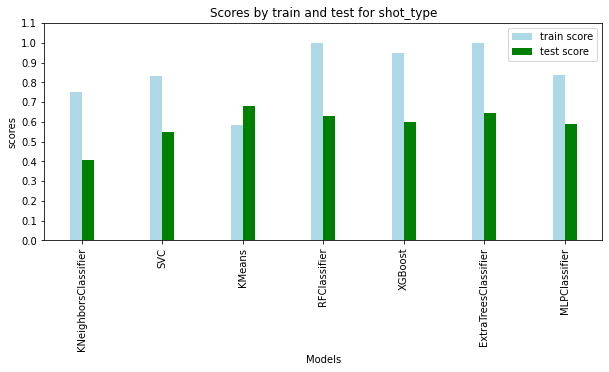

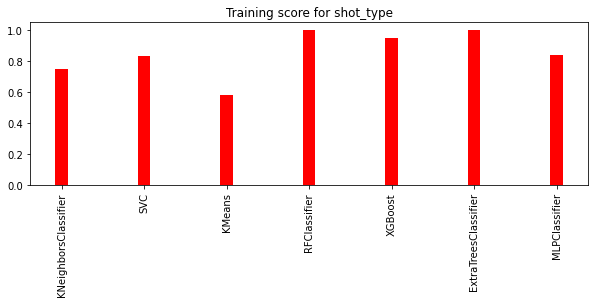

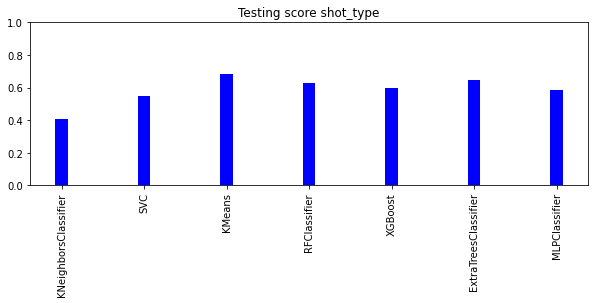




 Best Models for shot_type
['KMeans']


['shot_kind']
max
(980,)
(980, 9)


ground truth type shot_kind
KNeighborsClassifier


R2 test = 0.3368200836820084
score test = 33.68200836820084


R2 train = 0.45510204081632655
score train = 45.51020408163266


SVC


R2 test = 0.3493723849372385
score test = 34.93723849372385


R2 train = 0.5020408163265306
score train = 50.204081632653065


KMeans


R2 test = 0.25313807531380755
score test = -24752.153567464906


R2 train = 0.25204081632653064
score train = -47217.73458439764


RFClassifier


R2 test = 0.3179916317991632
score test = 31.799163179916317


R2 train = 1.0
score train = 100.0


XGBoost


R2 test = 0.3075313807531381
score test = 30.753138075313807


R2 train = 0.8183673469387756
score train = 81.83673469387756


ExtraTreesClassifier


R2 test = 0.32426778242677823
score test = 32.42677824267782


R2 train = 1.0
score train = 100.0


MLPClassifier


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(




R2 test = 0.301255230125523
score test = 30.125523012552303


R2 train = 0.5510204081632653
score train = 55.10204081632652




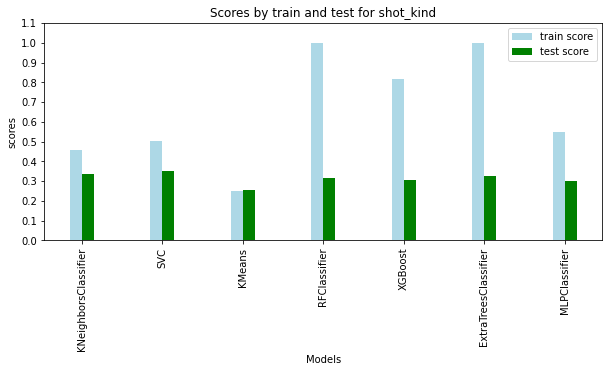

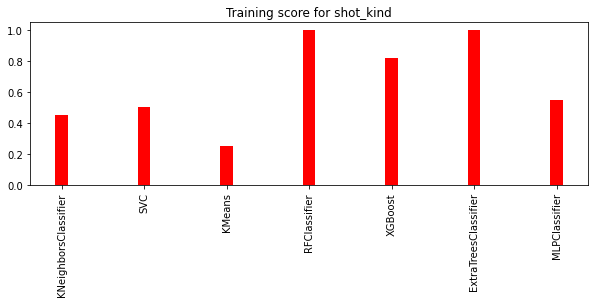

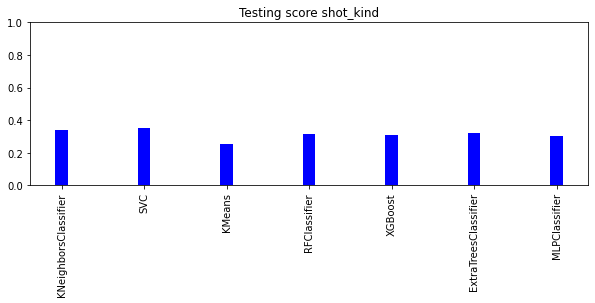




 Best Models for shot_kind
['SVC']




In [378]:
Playarena()

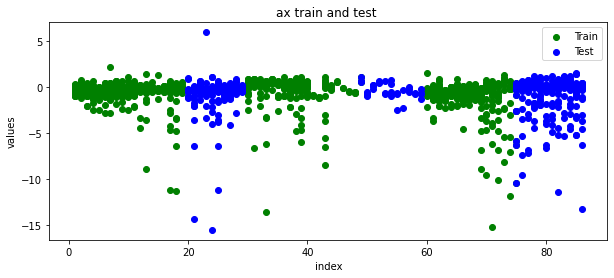

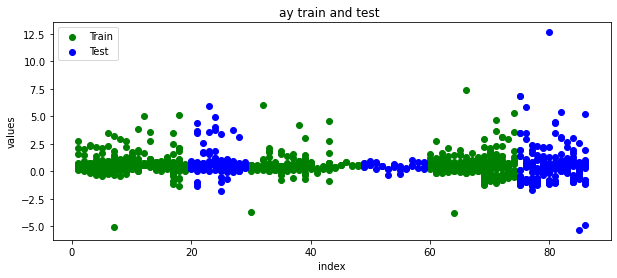

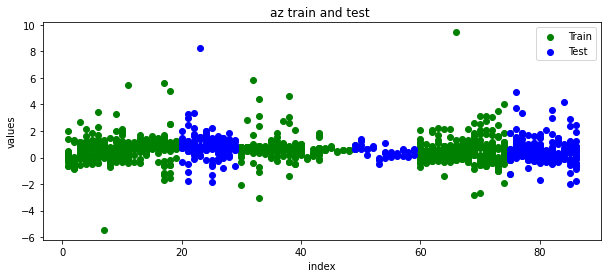

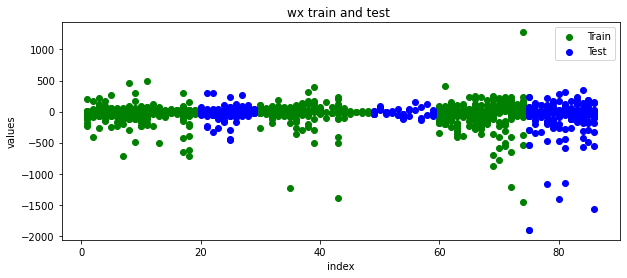

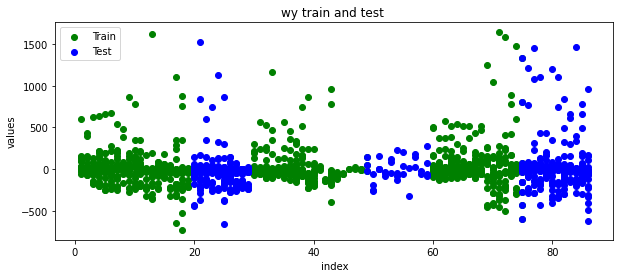

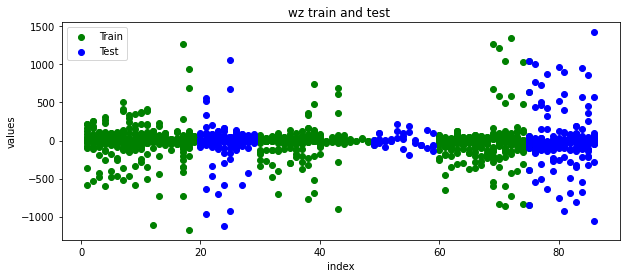

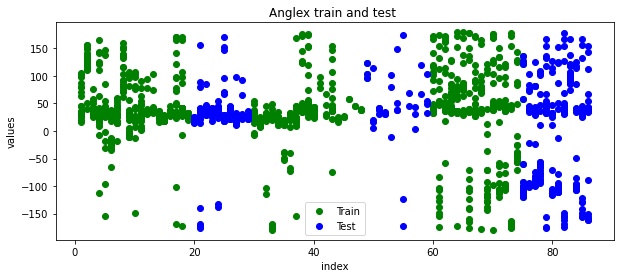

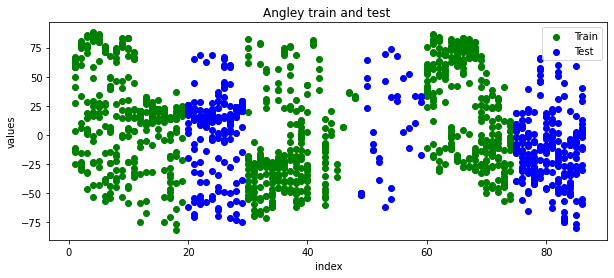

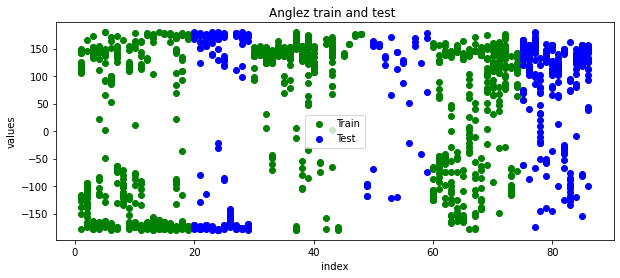

In [379]:
feature_plots(X_train_plot, X_test_plot,y_train_plot, y_test_plot)

Validating the shape,normalization and correlaion between features
.Printing the shapes of final data set of video and sesnor

In [380]:
print(final_video1_data_df.shape)
print(final_video2_data_df.shape)
print(final_video3_data_df.shape)
print(final_video5_data_df.shape)

(660, 1)
(780, 1)
(2099, 1)
(2099, 1)


In [381]:
print(final_sensor1_data.shape)
print(final_sensor2_data.shape)
print(final_sensor3_data.shape)
print(final_sensor5_data.shape)

(220, 14)
(272, 14)
(399, 14)
(544, 14)


In [382]:
print(len(ground_truth_final))

1435


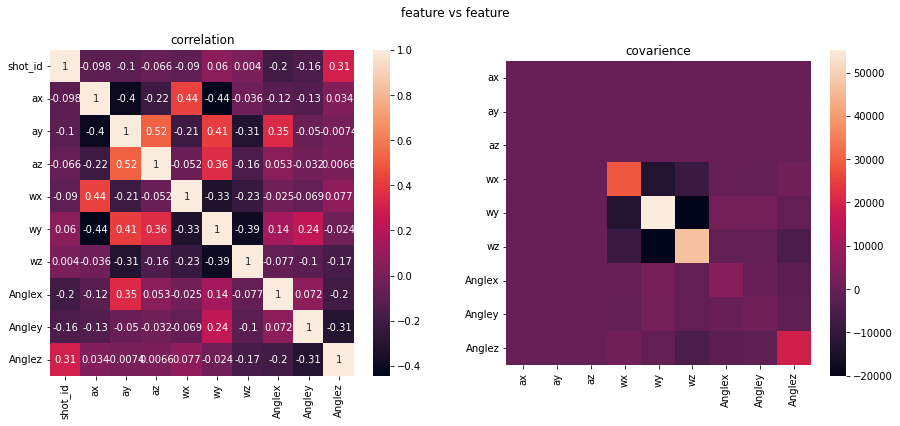

In [383]:
fig_correlation_covarience =correlation_covarience(x_cv)
# fig_correlation_covarience.show()

In [384]:
X_test_norm.max(axis=0)


ax        0.392559
ay        1.699782
az        0.876859
wx        0.184028
wy        0.931468
wz        1.057524
Anglex    0.991348
Angley    0.833115
Anglez    0.999756
dtype: float64

In [385]:
X_test_norm.min(axis=0)

ax       -1.023109
ay       -0.714757
az       -0.213810
wx       -1.000000
wy       -0.403155
wz       -0.836139
Anglex   -0.981962
Angley   -0.904557
Anglez   -0.999664
dtype: float64

In [386]:
model_best ="RFClassifier"
if  model_best in best_model_name :
 plt_feature_importance = feature_importance(best_model)

Hyper tunning for the tree based models on cross validation 

In [387]:
# # hyper tunning did nt worked

# # Random forest
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs1 = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2') #roc_auc
# gs1.fit(X_train_norm, y_train_enc_1)
# print('Best score:', gs1.best_score_)
# print('Best score:', gs1.best_params_)

In [388]:
# # hyper tunning

# # Random forest
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs4 = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# gs4.fit(X_train_norm, y_train_enc_2)
# print('Best score:', gs4.best_score_)
# print('Best score:', gs4.best_params_)

In [389]:
# # XGBoost
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.2, 0.5, 1]
# }

# gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# gs2.fit(X_train_norm, y_train_enc_1)

# print('Best score:', gs2.best_score_)
# print('Best score:', gs2.best_params_)

In [390]:
# # XGBoost
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.2, 0.5, 1]
# }

# gs5 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# gs5.fit(X_train_norm, y_train_enc_2)

# print('Best score:', gs5.best_score_)
# print('Best score:', gs5.best_params_)

In [391]:
# # Extra Tree
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs3 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# gs3.fit(X_train_norm, y_train_enc_1)

# print('Best score:', gs3.best_score_)
# print('Best score:', gs3.best_params_)

In [392]:
# # Extra Tree
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs6 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# gs6.fit(X_train_norm, y_train_enc_2)

# print('Best score:', gs6.best_score_)
# print('Best score:', gs6.best_params_)

In [393]:


# votes = [
#     ('rf', gs1.best_estimator_),
#     ('xgb', gs2.best_estimator_),
#     ('xt', gs3.best_estimator_)
# ]

# # soft voting based on weights
# votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
# votesClass_cv = cross_validate(votesClass, X_train_norm, y_train_enc_1, cv=KFold(3, random_state=123))
# votesClass.fit(X_train_norm, y_train_enc_1)

# votesClass_cv

In [394]:
# model = votesClass
# #model.fit(X_train, y_train)
# y_train_hat = model.predict(X_train_norm)
# y_test_hat = model.predict(X_test_norm)

In [395]:
# print(model)
# print('Train performance')
# print('-------------------------------------------------------')
# print(classification_report(y_train_enc_1, y_train_hat))

# print('Test performance')
# print('-------------------------------------------------------')
# print(classification_report(y_test_enc_1, y_test_hat))

# print('R2 score')
# print('-------------------------------------------------------')
# print(r2_score(y_test_enc_1, y_test_hat))
# print('')

In [396]:

# votes = [
#     ('rf', gs4.best_estimator_),
#     ('xgb', gs5.best_estimator_),
#     ('xt', gs6.best_estimator_)
# ]

# # soft voting based on weights
# votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
# votesClass_cv = cross_validate(votesClass, X_train_norm, y_train_enc_2, cv=KFold(3, random_state=123))
# votesClass.fit(X_train_norm, y_train_enc_2)

# votesClass_cv

In [397]:
# model = votesClass
# #model.fit(X_train, y_train)
# y_train_hat = model.predict(X_train_norm)
# y_test_hat = model.predict(X_test_norm)

In [398]:
# print(model)
# print('Train performance')
# print('-------------------------------------------------------')
# print(classification_report(y_train_enc_2, y_train_hat))

# print('Test performance')
# print('-------------------------------------------------------')
# print(classification_report(y_test_enc_2, y_test_hat))

# print('R2 score')
# print('-------------------------------------------------------')
# print(r2_score(y_test_enc_2, y_test_hat))
# print('')

Accuracy and loss for train model for Neural networks like MLP,LSTM

In [399]:
# # print out training and testing errors
# print('loss = '+ str(max(history.history["loss"])))
# print('val_loss = '+ str(max(history.history["val_loss"])))
# print('accuracy = '+ str(max(history.history["accuracy"])*100)) #categorical_accuracy
# print("\n")

Extras

Cross validation verfication for models

In [400]:
# # RFClassifier 84 6 features 500 

# # configure the cross-validation procedure
# cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# # define search space
# space = dict()
# space['n_estimators'] = [10, 100, 500,1000,1500,2000]
# space['max_features'] = [ 6,9]
# # define search
# search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# # configure the cross-validation procedure
# cv_outer = KFold(n_splits=10, shuffle=True)
# # execute the nested cross-validation
# scores = cross_val_score(search, x_cv, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# #scores =cross_val_score(model, x_cv, y, cv=5)
# #KNN_classifier,SVC when cv =5
# #skf = StratifiedKFold(n_splits=3)
# #kf = KFold(n_splits=3) kf.split(X, y)

Manual code without using cross_val_score

In [401]:
# # configure the cross-validation procedure
# cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# # enumerate splits
# outer_results = list()
# for train_ix, test_ix in cv_outer.split(x_cv):
#  # split data
#  X_train, X_test = x_cv[train_ix, :], x_cv[test_ix, :]
#  y_train, y_test = y[train_ix], y[test_ix]
#  # configure the cross-validation procedure
#  cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
#  # define the model
#  model = RandomForestClassifier(random_state=1)
#  # define search space
#  space = dict()
#  space['n_estimators'] = [10, 100, 500,1000,1500,2000]
#  space['max_features'] = [ 6,9]
#  # define search
#  search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
#  # execute search
#  result = search.fit(X_train, y_train)
#  # get the best performing model fit on the whole training set
#  best_model = result.best_estimator_
#  # evaluate model on the hold out dataset
#  yhat = best_model.predict(X_test)
#  # evaluate the model
#  acc = accuracy_score(y_test, yhat)
#  # store the result
#  outer_results.append(acc)
#  # report progress
#  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# # summarize the estimated performance of the model
# print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

Find best k for KNN classifier and regressor

In [402]:
# # for ground truth perfect or goog
# # knn regressor k=15
# # KNN classifer k=7
# # kmean 2

# # for ground truth attack defense
# # knn regressor k=94
# # KNN classifer k=290,292,303
# # kmean 2
# error = []
# end_range=500
# # Calculating MAE error for K values between 1 and 39
# for i in range(1, end_range):
#     knn = KMeans(n_clusters=i)
#     # knn = KNeighborsClassifier(n_neighbors=i)
#     # knn = KNeighborsRegressor(n_neighbors=i)
#     knn.fit(X_train_norm, y_train_enc_1)
#     pred_i = knn.predict(X_test_norm)
#     mae = mean_squared_error(y_test_enc_1, pred_i)
#     error.append(mae)

# plt.figure(figsize=(11, 6))
# plt.plot(range(1, end_range), error, color='red', 
#          linestyle='dashed', marker='o',
#          markerfacecolor='blue', markersize=10)
         
# plt.title('K Value MAE')
# plt.xlabel('K Value')
# plt.ylabel('Mean Absolute Error')

In [403]:
# def find_best_k(gt,model_name):
#   n=0
#   best_n=0
#   end_range=10
#   best_mae=100000000000.0
#   if gt =="shot_type":
#     error = []

#     # Calculating MAE error for K values between 1 and 39
#     for i in range(1, end_range):
#       # knn = KMeans(n_clusters=i)
#       # knn = KNeighborsClassifier(n_neighbors=i)
#       knn = KNeighborsRegressor(n_neighbors=i)
#       knn.fit(X_train_norm, y_train_enc_1)
#       pred_i = knn.predict(X_test_norm)
#       mae = mean_squared_error(y_test_enc_1, pred_i)
#       if mae < best_mae:
#         n=i
#       # error.append(mae)
#     # #ploting for better understanding
#     # plt.figure(figsize=(11, 6))
#     # plt.plot(range(1, end_range), error, color='red', 
#     #      linestyle='dashed', marker='o',
#     #      markerfacecolor='blue', markersize=10)
         
#     # plt.title('K Value MAE')
#     # plt.xlabel('K Value')
#     # plt.ylabel('Mean Absolute Error')
#   else:
#     error = []
#     # Calculating MAE error for K values between 1 and 39
#     for i in range(1, end_range):
#       # knn = KMeans(n_clusters=i)
#       # knn = KNeighborsClassifier(n_neighbors=i)
#       knn = KNeighborsRegressor(n_neighbors=i)
#       knn.fit(X_train_norm, y_train_enc_2)
#       pred_i = knn.predict(X_test_norm)
#       mae = mean_squared_error(y_test_enc_2, pred_i)
#       # error.append(mae)
#     # #ploting for better understanding
#     # plt.figure(figsize=(11, 6))
#     # plt.plot(range(1, end_range), error, color='red', 
#     #      linestyle='dashed', marker='o',
#     #      markerfacecolor='blue', markersize=10)
         
#     # plt.title('K Value MAE')
#     # plt.xlabel('K Value')
#     # plt.ylabel('Mean Absolute Error')
  # return n

download folder from colab to local

In [404]:
#  !zip -r shot1.zip /content/images

In [405]:
# def normalization(X,norm="mean_std"):
#   if norm=="mean_std":
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x - x.mean()) / np.std(x))

#   if norm=="min_max":
#     #df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
  
#   if norm=="max":
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x  / np.max(x)))

#   return X

In [406]:
# def normalization_1(X,norm="mean_std"):
#   if norm=="mean_std":
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0))

#   if norm=="min_max":
#     #df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)))
  
#   if norm=="max":
#     X[cols_main_norm] = X[cols_main_norm].apply(lambda x: (x  / x.max(axis=0)))
  
#   return X

Method 1 to find video and sensor shot cropping

In [407]:
# #shots time stamp in video
# video1_shots =[]
# video2_shots =[]
# video3_shots =[]
# video5_shots =[]


# # video 1
# for i,(et,st) in enumerate(zip(video1_et_s,video1_st_s)):
#   shot_time= (((st+et)/2)*1000)/video_granularity
#   # if i<5:
#   #  print(int(shot_time))
#   video1_shots.append(int(shot_time))

# # video 2
# for i,(et,st) in enumerate(zip(video2_et_s,video2_st_s)):
#   shot_time= (((st+et)/2)*1000)/video_granularity
#   # if i<5:
#   #  print(int(shot_time))
#   video2_shots.append(int(shot_time))

# # video 3
# for i,(et,st) in enumerate(zip(video3_et_s,video3_st_s)):
#   shot_time= (((st+et)/2)*1000)/video_granularity
#   # if i<5:
#   #  print(int(shot_time))
#   video3_shots.append(int(shot_time))

# # video 5
# for i,(et,st) in enumerate(zip(video5_et_s,video5_st_s)):
#   shot_time= (((st+et)/2)*1000)/video_granularity
#   # if i<5:
#   #  print(int(shot_time))
#   video5_shots.append(int(shot_time))

# #video 1
# rslt_video1_index = Sensor_data_1_align.index[Sensor_data_1_align['Date_Time'] == video1_save_time][:1].tolist()

# # Sensor_data_1_align.iloc[rslt_video1_index]
# # vidoe 2
# rslt_video2_index = Sensor_data_2_align.index[Sensor_data_2_align['Date_Time'] == video2_save_time][:1].tolist()
# #vidoe 3
# rslt_video3_index = Sensor_data_3_align.index[Sensor_data_3_align['Date_Time'] == video3_save_time][:1].tolist()
# #video 5
# rslt_video5_index = Sensor_data_5_align.index[Sensor_data_5_align['Date_Time'] == video5_save_time][:1].tolist()

# #shots time stamp in sensor data
# Sensor_data1_shots =[]
# Sensor_data2_shots =[]
# Sensor_data3_shots =[]
# Sensor_data5_shots =[]

# # video 1 & sensor data 1
# for i,(et,st) in enumerate(zip(video1_et_s,video1_st_s)):
#   shot_time= rslt_video1_index[0] + ((((st+et)/2)*1000)/sensor_granularity)
#   Sensor_data1_shots.append(int(shot_time))

# # video 2 & sensor data 1
# for i,(et,st) in enumerate(zip(video2_et_s,video2_st_s)):
#   shot_time=  ((((st+et)/2)*1000)/sensor_granularity)
#   Sensor_data2_shots.append(int(shot_time))

# # video 3 & sensor data 1
# for i,(et,st) in enumerate(zip(video3_et_s,video3_st_s)):
#   shot_time= ((((st+et)/2)*1000)/sensor_granularity)
#   Sensor_data3_shots.append(int(shot_time))

# # video 5 & sensor data 2
# for i,(et,st) in enumerate(zip(video5_et_s,video5_st_s)):
#   shot_time= rslt_video5_index[0] + ((((st+et)/2)*1000)/sensor_granularity)
#   Sensor_data5_shots.append(int(shot_time))

# # copying to other list

# video1_shots_start_index = video1_shots.copy()
# video2_shots_start_index = video2_shots.copy()
# video3_shots_start_index = video3_shots.copy()
# video5_shots_start_index = video5_shots.copy()


# Sensor_data1_shots_start_index = Sensor_data1_shots.copy()
# Sensor_data2_shots_start_index = Sensor_data2_shots.copy()
# Sensor_data3_shots_start_index = Sensor_data3_shots.copy()
# Sensor_data5_shots_start_index = Sensor_data5_shots.copy()

# #finding the start index
# video1_shots_start_index = [x - video_datapoints for x in video1_shots_start_index]
# video2_shots_start_index = [x - video_datapoints for x in video2_shots_start_index]
# video3_shots_start_index = [x - video_datapoints for x in video3_shots_start_index]
# video5_shots_start_index = [x - video_datapoints for x in video5_shots_start_index]

# #sensor data index
# Sensor_data1_shots_start_index = [x - sensor_datapoints for x in Sensor_data1_shots_start_index]
# Sensor_data2_shots_start_index = [x - sensor_datapoints for x in Sensor_data2_shots_start_index]
# Sensor_data1_shots_start_index = [x - sensor_datapoints for x in Sensor_data1_shots_start_index]
# Sensor_data2_shots_start_index = [x - sensor_datapoints for x in Sensor_data2_shots_start_index]

# final_video1_data = []
# final_video2_data = []
# final_video3_data = []
# final_video5_data = []


# #video 1
# count=0
# for i,index in enumerate(video1_shots_start_index):
#     for j,value in enumerate(timestamps_1_data):
#       if count <120:
#         final_video1_data.append(timestamps_1_data[index+count])
#         count=count+1
#     count=0

# #video 2
# count=0
# for i,index in enumerate(video2_shots_start_index):
#     for j,value in enumerate(timestamps_2_data):
#       if count <120:
#         final_video2_data.append(timestamps_2_data[index+count])
#         count=count+1
#     count=0


# #video 3
# count=0
# for i,index in enumerate(video3_shots_start_index):
#     for j,value in enumerate(timestamps_3_data):
#       if count <120:
#         final_video3_data.append(timestamps_3_data[index+count])
#         count=count+1
#     count=0


# #video 5
# count=0
# for i,index in enumerate(video5_shots_start_index):
#     for j,value in enumerate(timestamps_5_data):
#       if count <120:
#         final_video5_data.append(timestamps_5_data[index+count])
#         count=count+1
#     count=0

# # need to modify

# final_sensor1_data = pd.DataFrame()
# final_sensor2_data = pd.DataFrame()
# final_sensor3_data = pd.DataFrame()
# final_sensor5_data = pd.DataFrame()


# for i,index in enumerate(Sensor_data1_shots_start_index):
#    temp_df=Sensor_data_1_align.iloc[index:index+22]
#    final_sensor1_data = final_sensor1_data.append(temp_df, ignore_index=True)

# for i,index in enumerate(Sensor_data2_shots_start_index):
#    temp_df=Sensor_data_2_align.iloc[index:index+22]
#    final_sensor2_data = final_sensor2_data.append(temp_df, ignore_index=True)

# for i,index in enumerate(Sensor_data3_shots_start_index):
#    temp_df=Sensor_data_3_align.iloc[index:index+22]
#   #  print(temp_df.shape)
#    final_sensor3_data = final_sensor3_data.append(temp_df, ignore_index=True)

# for i,index in enumerate(Sensor_data5_shots_start_index):
#    temp_df=Sensor_data_5_align.iloc[index:index+22]
#    final_sensor5_data = final_sensor5_data.append(temp_df, ignore_index=True)